# Detection & Compare

對比別人已經做好的 spike train

reference https://zenodo.org/record/1413593#.YBjhgS3RZhG


In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
# Read data
fullpath = os.path.join('/','home','jovyan','indy','The_nwb_Raw_Dataset','indy_20170124_01.nwb')
f = h5py.File(fullpath, 'r')
data = f['/acquisition/timeseries/broadband/data']
conversion = data.attrs['conversion']
timestamps = f['/acquisition/timeseries/broadband/timestamps']

In [3]:
fs = 24414.0625 
dur = 1
start = 100
channel = 96
signal_length = (int) (dur * fs)

# index_of_begin and index_of_end
ib = (int) (start * fs)
ie = ib + signal_length
ch1 = data[ib:ie].T[1-1]
t = timestamps[ib:ie]
# time_of_begin and time_of_end
tb = min(t)
te = max(t)


In [4]:
#https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform
def butter_lowpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_highpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='highpass')
    return b, a

def butter_highpass_filter(data, cutoff_freq, nyq_freq, order=4):
    b, a = butter_highpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def find_spike(data, thr, dist):
    li = list()
    last = -dist
    for i in range(len(data)-2):
        if data[i+1] < thr:
            continue
        if data[i] < data[i+1] and data[i+1] > data[i-1] and i - last >= dist:
            li.append(i+1)
            last = i
    return np.array(li)

In [5]:
ch1 = np.array(ch1)
t = np.array(t)
cutoff_lp = 5000.0
cutoff_hp = 500.0
temp = butter_lowpass_filter(ch1, cutoff_lp, fs/2)
ch1_after = butter_highpass_filter(temp, cutoff_hp, fs/2 )


In [6]:
Thr = 4 * np.std(ch1_after)
print(Thr)
#ch1_spike = np.sort(np.append(t[ch1_after > Thr], t[ch1_after < -Thr]))
ch1_spike = np.sort(t[find_spike(-ch1_after, Thr, (int)(0.003*fs))])
print(len(ch1_spike))
print(ch1_spike)


112.991614331
27
[ 1498.05351278  1498.10004287  1498.16393982  1498.68031732  1498.72705221
  1498.73970872  1498.74306741  1498.74691761  1498.75642023  1498.76092579
  1498.76944538  1498.77927568  1498.78587017  1498.8348988   1498.85406789
  1498.87376945  1498.88474661  1498.89617434  1498.90985484  1498.91657221
  1498.92910585  1498.9372568   1498.94450665  1498.95359968  1498.97027023
  1498.97936326  1498.99500982]


In [7]:
fullpath = os.path.join('/','home','jovyan','indy','Sorted_Spike_Dataset','indy_20170124_01.mat')
f = h5py.File(fullpath, 'r')
temp = np.array([])
for i in range(len(f['spikes'])):
    temp = np.append(temp, np.array(f[f['spikes'][i][0]]))
temp = np.sort(temp)
temp = temp[temp > tb]
temp = temp[temp < te]
ch1_spike_markin = temp
print(len(ch1_spike_markin))
print(ch1_spike_markin)

19
[ 1498.0196392   1498.04552566  1498.10045246  1498.1640627   1498.68068596
  1498.7263559   1498.74011832  1498.74728624  1498.75674791  1498.78623881
  1498.83530839  1498.85443652  1498.88515621  1498.89658394  1498.9120257
  1498.92947448  1498.95400928  1498.97977285  1498.99541942]


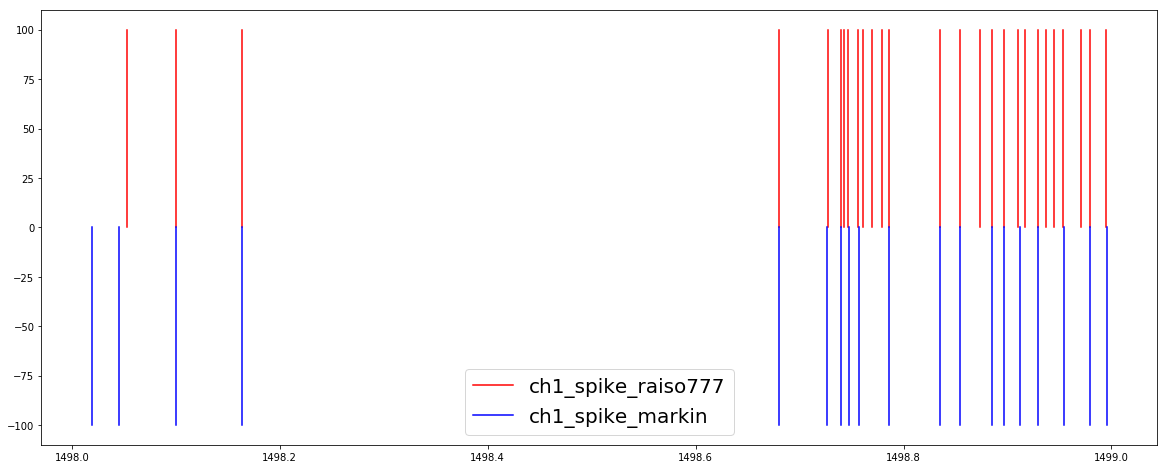

In [8]:
plt.figure(figsize=(20, 8))

for it in ch1_spike:
    plt.plot([it, it], [0, 100], 'r')
plt.plot([it], [0], 'r', label='ch1_spike_raiso777')
for it in ch1_spike_markin:
    plt.plot([it, it], [0, -100], 'b')  
plt.plot([it], [0], 'b', label='ch1_spike_markin') 
plt.legend(fontsize=20)
plt.show()